In [1]:
# single

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 50,
        x_rate = [0.5, 1.0],
        m_rate = [0.5, 1.0],
        weight_constraint = [-3.,3.],
        radioactive_rating = [0.1, 0.5],
        grow_factor = [0.1, 0.5],
        scale_hyperparameter = False,
        regularizer = None))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint

    model.optimizer.rr = model.optimizer.radioactive_rating[1] - (model.optimizer.radioactive_rating[1] - model.optimizer.radioactive_rating[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.gf = model.optimizer.grow_factor[1] - (model.optimizer.grow_factor[1] - model.optimizer.grow_factor[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.crossover_rate = model.optimizer.x_rate[1] - (model.optimizer.x_rate[1] - model.optimizer.x_rate[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.mutation_rate = model.optimizer.m_rate[0] + (model.optimizer.m_rate[1] - model.optimizer.m_rate[0]) / EPOCHS * (EPOCHS - itr)
    

C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))
C:\Users\tcumi\github_repo\neural-network\python\ga.py:201: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.9382716049382716, Loss: 0.3141869792231807
Checkpoint 200, Accuracy: 0.9444444444444444, Loss: 0.26108213707252786
Checkpoint 300, Accuracy: 0.9444444444444444, Loss: 0.2200619556285717
Checkpoint 400, Accuracy: 0.9629629629629629, Loss: 0.17249222154970523
Checkpoint 500, Accuracy: 0.9629629629629629, Loss: 0.13513037893507215


In [10]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 0. 1.] <-> [0.20724082 0.00094373 0.79181546]
[1. 0. 0.] <-> [9.147633e-01 8.939699e-04 8.434269e-02]
[1. 0. 0.] <-> [0.9741004  0.00107761 0.02482195]
[1. 0. 0.] <-> [9.8242468e-01 9.2140876e-04 1.6653830e-02]
[1. 0. 0.] <-> [9.181081e-01 8.815064e-04 8.101038e-02]
[1. 0. 0.] <-> [0.97851485 0.00144949 0.02003565]
[1. 0. 0.] <-> [9.8385620e-01 8.4874022e-04 1.5294956e-02]
[1. 0. 0.] <-> [9.5442778e-01 6.9107657e-04 4.4881161e-02]
[1. 0. 0.] <-> [0.98379654 0.001989   0.01421435]
[1. 0. 0.] <-> [0.9807241  0.00165795 0.01761802]
[0. 0. 1.] <-> [0.20499413 0.00094283 0.79406303]
[0. 0. 1.] <-> [0.21030036 0.00095693 0.7887427 ]
[1. 0. 0.] <-> [0.9784057  0.00167231 0.01992194]
[1. 0. 0.] <-> [0.9803812  0.00167786 0.01794088]
[1. 0. 0.] <-> [0.7137852  0.00143418 0.28478068]
[1. 0. 0.] <-> [0.9620696  0.00102477 0.03690565]
[0. 0. 1.] <-> [0.8627713  0.00119287 0.13603579]
[1. 0. 0.] <-> [0.92673796 0.03620814 0.03705392]
[1. 0. 0.] <-> [0.9837737  0.00255139 0.01367484]
[0. 0. 1.] 

In [12]:
# Testing Performance

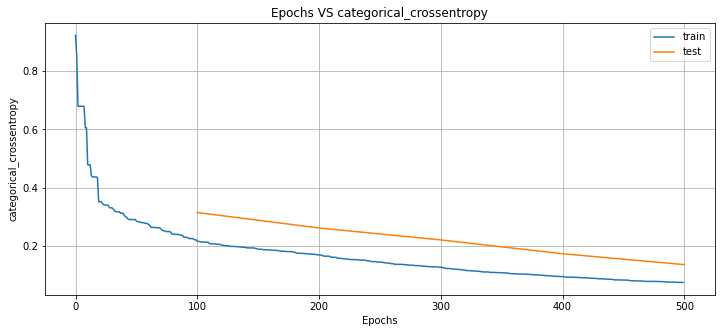

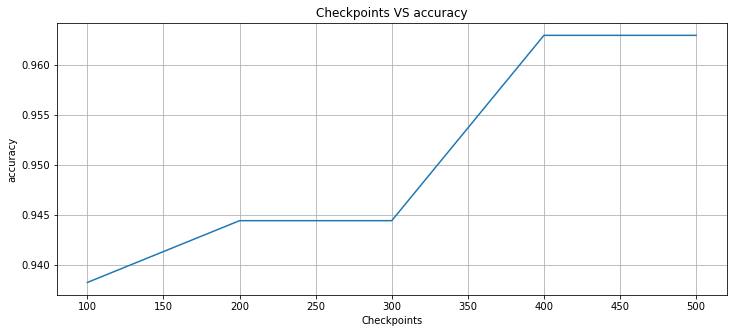

In [13]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9382716049382716, 'mean_square_error': 0.16102900762398656, 'categorical_crossentropy': 0.3141869792231807, 'precision': 0.9074074074074074, 'recall': 0.9074074074074074, 'f1': 0.9074074074074074, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 7, 'tn_hit': 25, 'fn_hit': 1}, 1: {'tp_hit': 14, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 3}, 2: {'tp_hit': 9, 'fp_hit': 3, 'tn_hit': 90, 'fn_hit': 6}}, 'checkpoint': 100} 


{'accuracy': 0.9444444444444444, 'mean_square_error': 0.13583030247603464, 'categorical_crossentropy': 0.26108213707252786, 'precision': 0.9166666666666666, 'recall': 0.9166666666666666, 'f1': 0.9166666666666666, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 8, 'tn_hit': 24, 'fn_hit': 1}, 1: {'tp_hit': 13, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 4}, 2: {'tp_hit': 11, 'fp_hit': 1, 'tn_hit': 92, 'fn_hit': 4}}, 'checkpoint': 200} 


{'accuracy': 0.9444444444444444, 'mean_square_error': 0.11785922661622629, 'categorical_crossentropy': 0.2200619556285717, 'precisio

In [15]:
print(model)

Layer 1
Neuron 0: weights:
[ 0.48472574 -1.6052755  -3.         -0.42227936  2.6390111 ]
 bias: 2.483565330505371

Neuron 1: weights:
[-1.400266    2.608748    0.93331456  1.8425976   2.7832267 ]
 bias: -0.23179885745048523

Neuron 2: weights:
[ 1.0850189  -2.7158144  -0.59929335  0.8387824   1.2830061 ]
 bias: -2.8340463638305664

Neuron 3: weights:
[ 1.3319279 -1.9809797 -1.3164961 -0.524813   2.4461286]
 bias: 2.5971481800079346

$
Layer 2
Neuron 0: weights:
[-0.18097262 -1.6059245  -3.          2.513925  ]
 bias: 1.6247999668121338

Neuron 1: weights:
[-3.          3.         -0.30198202 -3.        ]
 bias: 1.866437315940857

Neuron 2: weights:
[-0.29228538  0.4867742   3.          2.2541673 ]
 bias: -2.6416015625

$

